# Example: Pseudo-contact shift

In [1]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

## Build the spin-system

In [2]:
ex=RS.ExpSys(v0H=850,Nucs=['13C','e-'],T_K=100)
Aiso=100000.
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=Aiso,Ayy=Aiso,Azz=Aiso)
print(f'We expect a pseudo-contact shift of {Aiso*ex.Peq[1]} Hz')

We expect a pseudo-contact shift of -672.4826324530147 Hz


## Define the Liouvillian, add relaxation, acquire the propagator

Note that by default, we do not cause the system to relax to thermal equilibrium, but rather to 0. However, for the Pseudocontact shift, we only obtain the effect if the electronic states have thermal polarization, so we need to enforce relaxation to thermal equilibrium (Peq=True).

In [3]:
L=RS.Liouvillian(ex)     #Liouville object
L.add_relax(Type='T1',i=1,T1=1e-9,Peq=True)  #Add T1 relaxation (1 ns). 
L.add_relax(Type='T2',i=1,T2=1e-11) #Add T2 relaxation (ensure physical system)
dt=1/1000/2 #Short enough time step for 2000 Hz spectral width
U=L.U(t0=0,tf=dt)

## Acquire a spectrum

/Users/albertsmith/Documents/GitHub/pyRelaxSim/Rho.py:305: RuntimeWarning: overflow encountered in multiply
  rho_d=dp*rho0
/Users/albertsmith/Documents/GitHub/pyRelaxSim/Rho.py:305: RuntimeWarning: invalid value encountered in multiply
  rho_d=dp*rho0
/Users/albertsmith/Documents/GitHub/pyRelaxSim/Rho.py:309: RuntimeWarning: invalid value encountered in multiply
  self._Ipwd[k][m].extend((det_d*rho_d[:-1]).sum(-1))
/Users/albertsmith/Documents/GitHub/pyRelaxSim/Rho.py:144: RuntimeWarning: invalid value encountered in multiply
  return (self.Ipwd.T*self.pwdavg.weight).sum(-1).T
/Users/albertsmith/Documents/GitHub/pyRelaxSim/Rho.py:144: RuntimeWarning: invalid value encountered in multiply
  return (self.Ipwd.T*self.pwdavg.weight).sum(-1).T


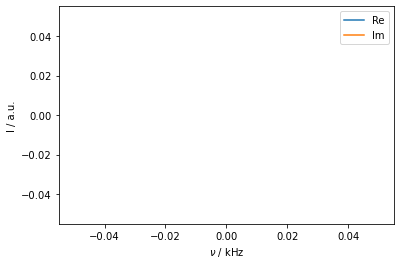

In [8]:
rho=RS.Rho(rho0='13Cx',detect='13Cp',L=L)
rho.DetProp(U,n=2000)
rho.plot(FT=True)

In [10]:
rho.I[0,0]

/Users/albertsmith/Documents/GitHub/pyRelaxSim/Rho.py:144: RuntimeWarning: invalid value encountered in multiply
  return (self.Ipwd.T*self.pwdavg.weight).sum(-1).T


(1+0j)

In [11]:
U[0]

array([[-2.5000000e+05+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  2.5000000e+05+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j],
       [ 0.0000000e+00+0.00000000e+00j, -5.0000000e+07-1.28255005e+02j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.000000

In [12]:
d,v=np.linalg.eig(L[0].L(0))

In [13]:
d

array([ 1.3724588e-23     +0.j  , -1.0000000e+09     +0.j  ,
        1.3724588e-23     +0.j  , -1.0000000e+09     +0.j  ,
        1.3724589e-23+256509.98j, -1.0000000e+09+256509.98j,
        1.3724589e-23+256509.98j, -1.0000000e+09+256509.98j,
       -9.9999998e+10-256509.98j, -9.9999998e+10-256509.98j,
       -9.9999998e+10     +0.j  , -9.9999998e+10     +0.j  ,
       -9.9999998e+10     +0.j  , -9.9999998e+10     +0.j  ,
       -9.9999998e+10-256509.98j, -9.9999998e+10-256509.98j],
      dtype=complex64)

In [14]:
U[0]

array([[-2.5000000e+05+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  2.5000000e+05+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j],
       [ 0.0000000e+00+0.00000000e+00j, -5.0000000e+07-1.28255005e+02j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j,  0.0000000e+00+0.000000